### Imports

In [1]:
import os
import h5py as h5
import json

import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
    
# local imports (found in this repo)
from utils import *
from deconv import *
from releaser import Releaser, mini_releaser
from animator import SacSacAnimator, ball_sticks
from scalebars import add_scalebar

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

In [6]:
base_path = "/mnt/Data/NEURONoutput/" + "sac_sac/"
model_path = base_path + "model_runs/elife_resub/"

with h5.File(os.path.join(model_path, "sust_trans_20tr.h5"), "r") as f:
    sust_trans = unpack_hdf(f)[0]

with h5.File(os.path.join(model_path, "trans_sust_20tr.h5"), "r") as f:
    trans_sust = unpack_hdf(f)
    
first_cond = list(sust_trans.keys())[0]
print("params condition: %s" % first_cond)
st_model_params = json.loads(sust_trans[first_cond]["model_params"])
st_exp_params = json.loads(sust_trans[first_cond]["exp_params"])
ts_model_params = json.loads(trans_sust[first_cond]["model_params"])
ts_exp_params = json.loads(trans_sust[first_cond]["exp_params"])
sust_trans = {k: v["data"] for k, v in sust_trans.items()}
trans_sust = {k: v["data"] for k, v in trans_sust.items()}

for exp in [sust_trans, trans_sust]:
    for cond in exp.keys():
        exp[cond]["combined_bps"] = {
            n: {
                m: np.sum(
                    [bp[m] for bps in sac.values() for bp in bps.values()], axis=0
                )
                for m in ["g", "i"]
            }
            for n, sac in exp[cond]["bps"].items()
        }
        exp[cond]["combined_gaba"] = {
            n: {
                m: np.sum([syn[m] for syn in sac.values()], axis=0)
                for m in ["g", "i"]
            }
            for n, sac in exp[cond]["gaba"].items()
        }

avg_sust_trans = apply_to_data(lambda a: np.mean(a, axis=0), sust_trans)
avg_trans_sust = apply_to_data(lambda a: np.mean(a, axis=0), trans_sust)
exps = {"st": sust_trans, "ts": trans_sust}

params condition: no_gaba


### Common axes, labels, and parameters generated or pulled from the control experiment data which apply to all conditions

In [7]:
dt = st_exp_params["dt"]
rec_xaxis = np.arange(0, st_exp_params["tstop"] + dt, dt)
velocities = st_exp_params["velocities"]

### Experiment dict contents / shapes

In [8]:
print("Electrode recording dict keys:", [k for k in sust_trans[first_cond]["soma"]["a"].keys()])
print("Synapse recording dict keys:", [k for k in sust_trans[first_cond]["gaba"]["a"].keys()])
print("Recording shape:", sust_trans[first_cond]["soma"]["a"]["v"].shape)

Electrode recording dict keys: ['cai', 'ica', 'v']
Synapse recording dict keys: [0, 1, 2, 3, 4]
Recording shape: (20, 10, 6001)


<IPython.core.display.Javascript object>


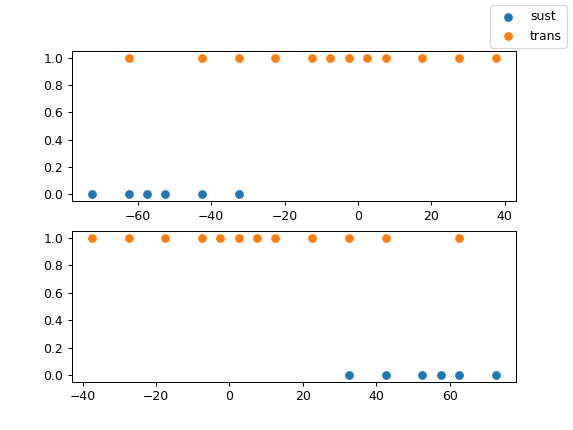

In [9]:
ff, aa = plt.subplots(2)
a_locs = st_model_params["a"]["bp_xy_locs"]
b_locs = st_model_params["b"]["bp_xy_locs"]
aa[0].scatter(a_locs["sust"]["x"], a_locs["sust"]["y"] , label="sust")
aa[0].scatter(a_locs["trans"]["x"], np.array(a_locs["trans"]["y"]) + 1, label="trans")
aa[1].scatter(b_locs["sust"]["x"], b_locs["sust"]["y"])
aa[1].scatter(b_locs["trans"]["x"], np.array(b_locs["trans"]["y"]) + 1)
ff.legend()

### Model Schematic and Animation
Colours are normalized to the maximum values of their corresponding measures across all velocities and both SACs in a particular condition. Thus, for the matching visible components (e.g. 2nd trans BPCs or terminals), the colour scaling is shared.

- **soma:** membrane voltage at centre
- **terminal:** membrane voltage at tip (GABA pre-synapse)
- **bipolars:** conductance
- **GABA:** conductance

<IPython.core.display.Javascript object>


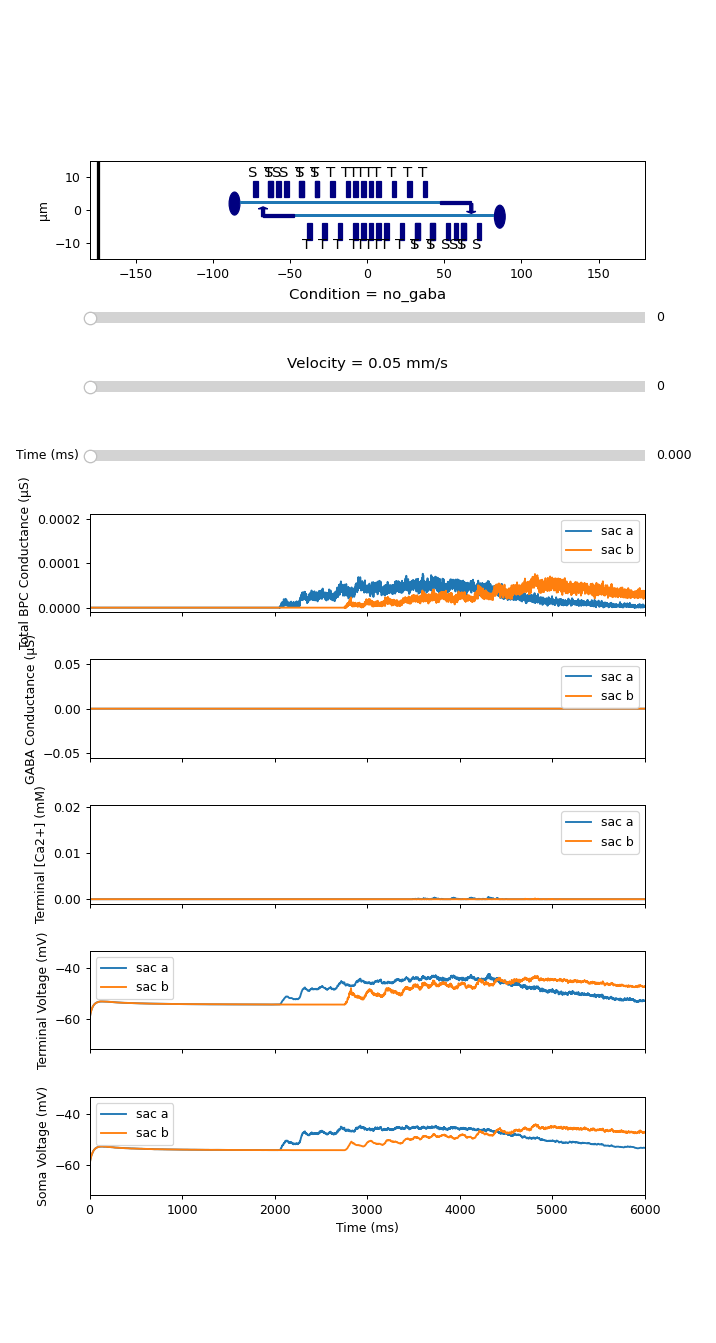

In [10]:
sac_anim = SacSacAnimator(
    sust_trans,
    st_exp_params,
    st_model_params, 
    reveal_time=False
)
# sac_anim = SacSacAnimator(
#     trans_sust,
#     ts_exp_params,
#     ts_model_params, 
#     reveal_time=False
# )
sac_anim_fig, sac_anim_ax = sac_anim.build_interactive_fig(figsize=(8, 15))

### PN DSi measurements
Here the bar is simply moving in the same direction, over SAC A then SAC B, but we can use the signals in the opposing SACs to calculate a preferred minus null direction selective index.

- **peak:** Using the deflection from the minimum voltage
- **thresh_area:** Area under the voltage above a specified threshold
- **iCa**: Area of calcium current (polarity flipped to positive)
- **gaba:** Area of GABA conductance *applied* the *opposing* SAC  

In [12]:
thresh = -40
dsis = {
    k: { 
        cond: {
            "peak": pn_dsi(
                peak_vm_deflection(exp["term"]["a"]["v"]),
                peak_vm_deflection(exp["term"]["b"]["v"])
            ),
            "thresh_area": pn_dsi(
                thresholded_area(exp["term"]["a"]["v"], thresh),
                thresholded_area(exp["term"]["b"]["v"], thresh)
            ),
            "iCa": pn_dsi(
                np.sum(exp["term"]["a"]["ica"] * -1, axis=-1),
                np.sum(exp["term"]["b"]["ica"] * -1, axis=-1)
            ),
            "gaba": pn_dsi(
                np.sum(exp["combined_gaba"]["b"]["g"], axis=-1), 
                np.sum(exp["combined_gaba"]["a"]["g"], axis=-1)
            ),
            "peak_[Ca]": pn_dsi(
                np.max(exp["term"]["a"]["cai"], axis=-1),
                np.max(exp["term"]["b"]["cai"], axis=-1)
            ),
        }
        for cond, exp in es.items()
    } 
    for k, es in exps.items()
}

### Velocity Tuning of PN DSi
The above measurements of PN DSi for each of the experimental conditions.
- **control:** sustained-transient bipolar time constants and reciprocal GABA are intact
- **no_gaba:** bipolar mechanism remains, while GABA synapses are removed
- **uniform:** bipolar time constants are all the same (no prox-distal difference)
- **no_mechs:** bipolar time constants are uniform, and GABA synapses are removed

<IPython.core.display.Javascript object>


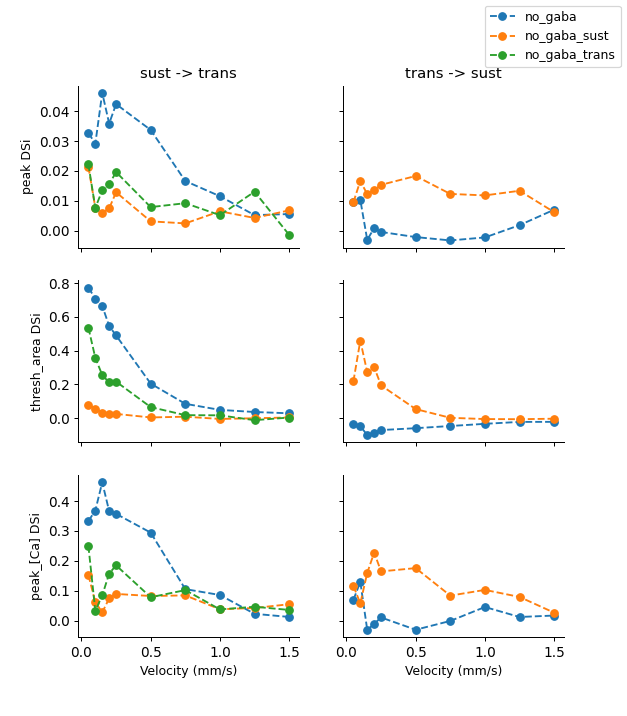

In [13]:
show_metrics = ["peak", "thresh_area", "peak_[Ca]"]
k_to_title = {"st": "sust -> trans", "ts": "trans -> sust"}

dsi_fig, dsi_ax = plt.subplots(
    len(show_metrics), 2, sharex=True, sharey="row", figsize=(7, 8))
for col, k in enumerate(dsis.keys()):
    for (cond, ds) in dsis[k].items():
        for i, m in enumerate(show_metrics):
            if not i:
                dsi_ax[i][col].set_title(k_to_title[k])
            lbl = {"label": cond} if not i and not col else {}  # only add label once for each condition
            dsi_ax[i, col].plot(
                velocities, np.mean(ds[m], axis=0), linestyle="--", marker="o", **lbl)

for row, metric in zip(dsi_ax, show_metrics):
    row[0].set_ylabel("%s DSi" % metric)
    clean_axes(row)

dsi_ax[-1][0].set_xlabel("Velocity (mm/s)")
dsi_ax[-1][1].set_xlabel("Velocity (mm/s)")
dsi_fig.legend()
dsi_fig.show()

<IPython.core.display.Javascript object>


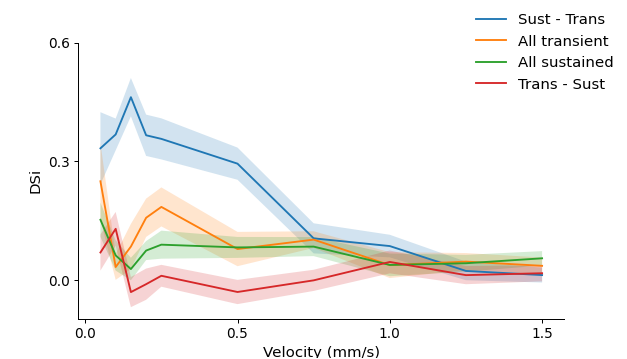

In [14]:
st_no_gaba_mean = np.mean(dsis["st"]["no_gaba"]["peak_[Ca]"], axis=0)
st_no_gaba_std = np.std(dsis["st"]["no_gaba"]["peak_[Ca]"], axis=0)
st_no_gaba_ste = st_no_gaba_std / np.sqrt(dsis["st"]["no_gaba"]["peak_[Ca]"].shape[0])
no_gaba_trans_mean = np.mean(dsis["st"]["no_gaba_trans"]["peak_[Ca]"], axis=0)
no_gaba_trans_std = np.std(dsis["st"]["no_gaba_trans"]["peak_[Ca]"], axis=0)
no_gaba_trans_ste = no_gaba_trans_std / np.sqrt(dsis["st"]["no_gaba_trans"]["peak_[Ca]"].shape[0])
no_gaba_sust_mean = np.mean(dsis["st"]["no_gaba_sust"]["peak_[Ca]"], axis=0)
no_gaba_sust_std = np.std(dsis["st"]["no_gaba_sust"]["peak_[Ca]"], axis=0)
no_gaba_sust_ste = no_gaba_sust_std / np.sqrt(dsis["st"]["no_gaba_sust"]["peak_[Ca]"].shape[0])
ts_no_gaba_mean = np.mean(dsis["ts"]["no_gaba"]["peak_[Ca]"], axis=0)
ts_no_gaba_std = np.std(dsis["ts"]["no_gaba"]["peak_[Ca]"], axis=0)
ts_no_gaba_ste = ts_no_gaba_std / np.sqrt(dsis["ts"]["no_gaba"]["peak_[Ca]"].shape[0])

peak_ca_fig, peak_ca_ax = plt.subplots(1, figsize=(7, 4))
peak_ca_ax.fill_between(
    velocities, st_no_gaba_mean + st_no_gaba_ste, st_no_gaba_mean - st_no_gaba_ste, alpha=0.2)
peak_ca_ax.plot(velocities, st_no_gaba_mean, label="Sust - Trans")
peak_ca_ax.fill_between(
    velocities, no_gaba_trans_mean + no_gaba_trans_ste, no_gaba_trans_mean - no_gaba_trans_ste, alpha=0.2)
peak_ca_ax.plot(velocities, no_gaba_trans_mean, label="All transient")
peak_ca_ax.fill_between(
    velocities, no_gaba_sust_mean + no_gaba_sust_ste, no_gaba_sust_mean - no_gaba_sust_ste, alpha=0.2)
peak_ca_ax.plot(velocities, no_gaba_sust_mean, label="All sustained")
peak_ca_ax.fill_between(
    velocities, ts_no_gaba_mean + ts_no_gaba_ste, ts_no_gaba_mean - ts_no_gaba_ste, alpha=0.2)
peak_ca_ax.plot(velocities, ts_no_gaba_mean, label="Trans - Sust")

peak_ca_ax.set_ylabel("DSi", fontsize=12)
peak_ca_ax.set_xlabel("Velocity (mm/s)", fontsize=12)
peak_ca_ax.set_xticks([0., 0.5, 1., 1.5])
peak_ca_ax.set_yticks([0., 0.3, 0.6])
clean_axes(peak_ca_ax)
peak_ca_fig.legend(fontsize=12, frameon=False)
peak_ca_fig.show()

for ext in [".svg", ".png"]:
    peak_ca_fig.savefig(
        os.path.join(model_path, "velocity_falloff" + ext), bbox_inches="tight")

<IPython.core.display.Javascript object>


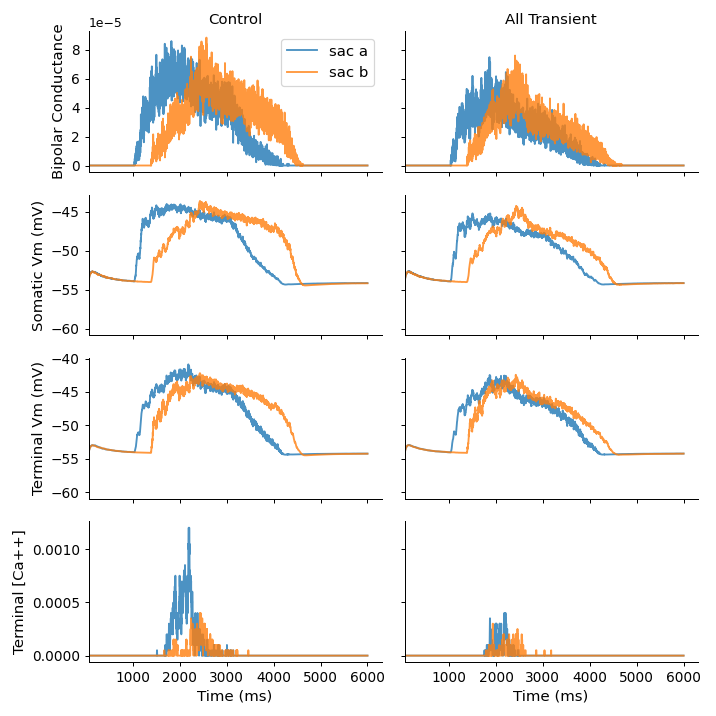

velocity = 0.100000 mm/s


In [31]:
exp_idx = "st"
vel_idx = 1
display_conds = ["no_gaba", "no_mechs"]
cond_to_title = {"no_gaba": "Control", "no_mechs": "All Transient"}

ex_fig, ex_ax = plt.subplots(
    4,
    len(display_conds),
    sharex="col",
    sharey="row",
    figsize=(8, 8)
)
ex_ax = np.expand_dims(ex_ax, 1) if len(display_conds) == 1 else ex_ax

for i, cond in enumerate(display_conds):
    if not i:
        ex_ax[0][i].set_ylabel("Bipolar Conductance", fontsize=12)
        ex_ax[1][i].set_ylabel("Somatic Vm (mV)", fontsize=12)
        ex_ax[2][i].set_ylabel("Terminal Vm (mV)", fontsize=12)
        ex_ax[3][i].set_ylabel("Terminal [Ca++]", fontsize=12)
    
    for n in exps[exp_idx][cond]["term"].keys():
        lbl = "sac %s" % n
        ex_ax[0][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["combined_bps"][n]["g"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        )
        ex_ax[1][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["soma"][n]["v"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        ) 
        ex_ax[2][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["term"][n]["v"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        )
        ex_ax[3][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["term"][n]["cai"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        )
    ex_ax[0][i].set_title(cond_to_title[cond])
    ex_ax[-1][i].set_xlabel("Time (ms)", fontsize=12)

for row in ex_ax:
    for col in row:
        clean_axes(col)
        
for ax in ex_ax[-1]:
    ax.set_xlim(50)
    
ex_ax[0][0].legend(fontsize=12)
ex_fig.tight_layout()
ex_fig.show()

print("velocity = %f mm/s" % velocities[vel_idx])
name = "control_vs_all_trans_%ium" % (velocities[vel_idx] * 1000)
for ext in [".svg", ".png"]:
    ex_fig.savefig(os.path.join(model_path, name + ext), bbox_inches="tight")

<IPython.core.display.Javascript object>


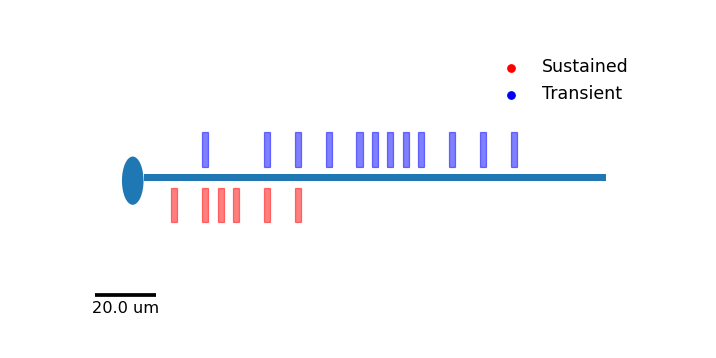

In [12]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ball_sticks(ax, st_model_params, y_off={"a": 0}, bp_width=2, incl_gaba=False)
ax.set_xlim(-100, 80)
ax.set_ylim(-20, 20)
# clean_axes(ax)
add_scalebar(
    ax,
    matchy=False,
    xfmt="%.1f um",
    sep=5,
    barwidth=3,
    fontsize=13,
    loc=3,
)
fig.savefig(os.path.join(base_path, "solo_sac_schematic.svg"), bbox_inches="tight")